# 1. Introduction 

## 1.1 Data Loading
- Load the dataset, libraries

In [379]:
# Importing necessary libraries
## CORE DATA HANDLING & EXPLORATION
import pandas as pd
import numpy as np
import re

## TEXT REPROCESSING & NLP
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import corpora, models
from nltk.util import ngrams
from gensim.corpora import Dictionary

## DATA VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pyLDAvis.gensim_models as gensimvis

## MACHINE LEARNING 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import LdaModel
from sklearn.decomposition import LatentDirichletAllocation

## ADDITIONAL UTILITIES
from collections import Counter
from tqdm import tqdm


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/linhdao/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/linhdao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/linhdao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [380]:
# Load the dataset
df = pd.read_csv('/Users/linhdao/Library/CloudStorage/OneDrive-TheUniversityOfNewcastle/BUSA3001/individual assessment/reviews_data.csv')
df

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...
...,...,...,...,...,...,...
845,Becky,"Agoura Hills, CA","Reviewed July 13, 2006",NaN,I ordered two venti frappacino's without whipp...,['No Images']
846,Bob,"Goodrich, MI","Reviewed Jan. 3, 2005",NaN,No Review Text,['No Images']
847,Erik,"Valley Village, CA","Reviewed Nov. 5, 2004",NaN,"DEMANDED TIPS FROM ME, THEN MADE ME WAIT UNTIL...",['No Images']
848,Andrew,"Fallbrook, CA","Reviewed Oct. 20, 2004",NaN,No Review Text,['No Images']


## 1.2 Data Exloration
- Explore the data basis characteristics: shapes, datatype, missing values, descriptive statistics

In [381]:
# Shape
print("Shape of the dataset:", df.shape)

# Data types
print("\nData types of each column:")
print(df.dtypes)

# Missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Descriptive statistics
print("\nDescriptive statistics:")
print(df.describe(include='all'))

Shape of the dataset: (850, 6)

Data types of each column:
name            object
location        object
Date            object
Rating         float64
Review          object
Image_Links     object
dtype: object

Missing values in each column:
name             0
location         0
Date             0
Rating         145
Review           0
Image_Links      0
dtype: int64

Descriptive statistics:
         name      location                     Date      Rating  \
count     850           850                      850  705.000000   
unique    604           633                      741         NaN   
top     Linda  New York, NY  Reviewed Sept. 14, 2017         NaN   
freq       13            14                        4         NaN   
mean      NaN           NaN                      NaN    1.870922   
std       NaN           NaN                      NaN    1.397672   
min       NaN           NaN                      NaN    1.000000   
25%       NaN           NaN                      NaN    1.000

## 1.3 Data Preparation
- Handle missing values (drop or impute)
- Filter relevant columns (keep only text and rating columns)
- Convert ratings to sentiment labels (1-3 stars > Negative)

In [382]:
# Handle missing values
df = df.dropna(subset=['Rating'])

# Turn Date column to datetime
df['Date'] = df['Date'].str.replace('Reviewed ', '', regex=False)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

# Filter Relevant Columns
df1 = df[['Review', 'Rating', 'Date']]

#Turn Rating into int
df1['Rating'] = df1['Rating'].astype(int)

# Convert Ratings to Sentiment Labels
def convert_rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'
    
df1['Sentiment'] = df1['Rating'].apply(convert_rating_to_sentiment)

df1


/var/folders/s_/hv64l0cd1x3dn8nddm3v52n80000gn/T/ipykernel_15104/2442294222.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].str.replace('Reviewed ', '', regex=False)
/var/folders/s_/hv64l0cd1x3dn8nddm3v52n80000gn/T/ipykernel_15104/2442294222.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
/var/folders/s_/hv64l0cd1x3dn8nddm3v52n80000gn/T/ipykernel_15104/2442294222.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

,Review,Rating,Date,Sentiment
0,Amber and LaDonna at the Starbucks on Southwes...,5,2023-09-13,positive
1,** at the Starbucks by the fire station on 436...,5,2023-07-16,positive
2,I just wanted to go out of my way to recognize...,5,2023-07-05,positive
3,Me and my friend were at Starbucks and my card...,5,2023-05-26,positive
4,I’m on this kick of drinking 5 cups of warm wa...,5,2023-01-22,positive
...,...,...,...,...
700,I ordered Via Starbucks coffee online. I recei...,1,2011-10-02,negative
701,"My name is Ric **, I am journalist by professi...",3,2011-08-31,neutral
702,"The bagel was ice cold, not cut and not toasted.",1,2011-08-24,negative
703,"In the morning of Monday, August 15, 2011, at ...",1,2011-08-15,negative


## 1.4 Data Analysis & Preprocessing
- Data Analysis
- Text CLeaning: Lowercase text, remove punctuation/ special chars
- Basic tokenization (splitting text into words, remove stopwords)
- Exploratory Analysis: Calculate review lengths, Compare lengths vs. sentiment (Are negative reviews longer?)
- Extract bigrams/ trigrams

/Users/linhdao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/linhdao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


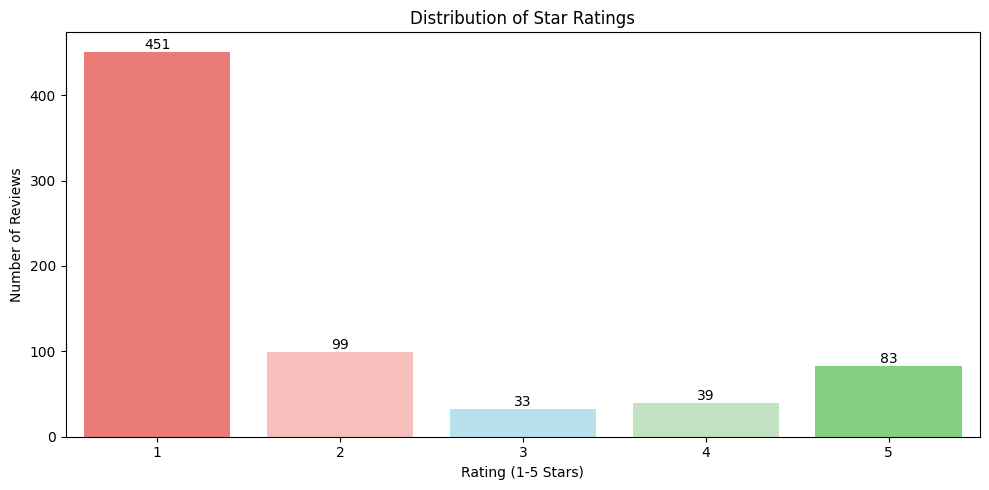

In [383]:
# Custom color palette for ratings
custom_palette = {
    1: '#FF6962',  # Warm color for 1 star (red)
    2: '#FFB6B3',  # Warm color for 2 stars (orange)
    3: '#b1e6f3',  # Neutral color for 3 stars (yellow)
    4: '#BDE7BD',  # Cool color for 4 stars (blue)
    5: '#77DD76'   # Cool color for 5 stars (green)
}


plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df1, x='Rating', order=sorted(df1['Rating'].unique()), palette=custom_palette)

# Add counts on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.title('Distribution of Star Ratings')
plt.xlabel('Rating (1-5 Stars)')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

/Users/linhdao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/linhdao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


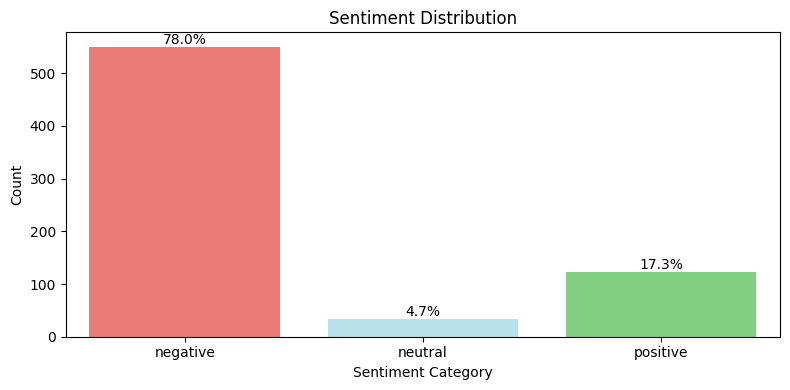

In [384]:
plt.figure(figsize=(8, 4))
sentiment_order = ['negative', 'neutral', 'positive']  # Customize order if needed
ax = sns.countplot(data=df1, x='Sentiment', order=sentiment_order, palette= ['#FF6962', '#b1e6f3', '#77DD76'])

# Add percentages
total = len(df1)
for p in ax.patches:
    percentage = 100 * p.get_height() / total
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

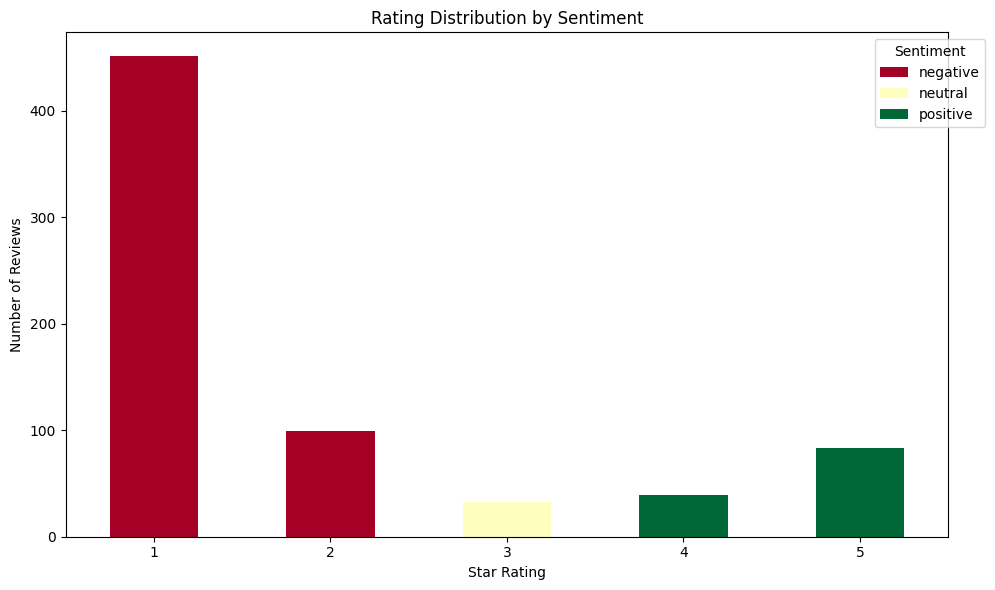

In [385]:
# Cross-tabulation
rating_sentiment = pd.crosstab(df1['Rating'], df1['Sentiment'])

# Stacked bar plot
rating_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6), colormap= "RdYlGn")
plt.title('Rating Distribution by Sentiment')
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

/var/folders/s_/hv64l0cd1x3dn8nddm3v52n80000gn/T/ipykernel_15104/2948145955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Year'] = pd.to_datetime(df1['Date']).dt.year
/Users/linhdao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/linhdao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/linhdao/anaconda3/lib

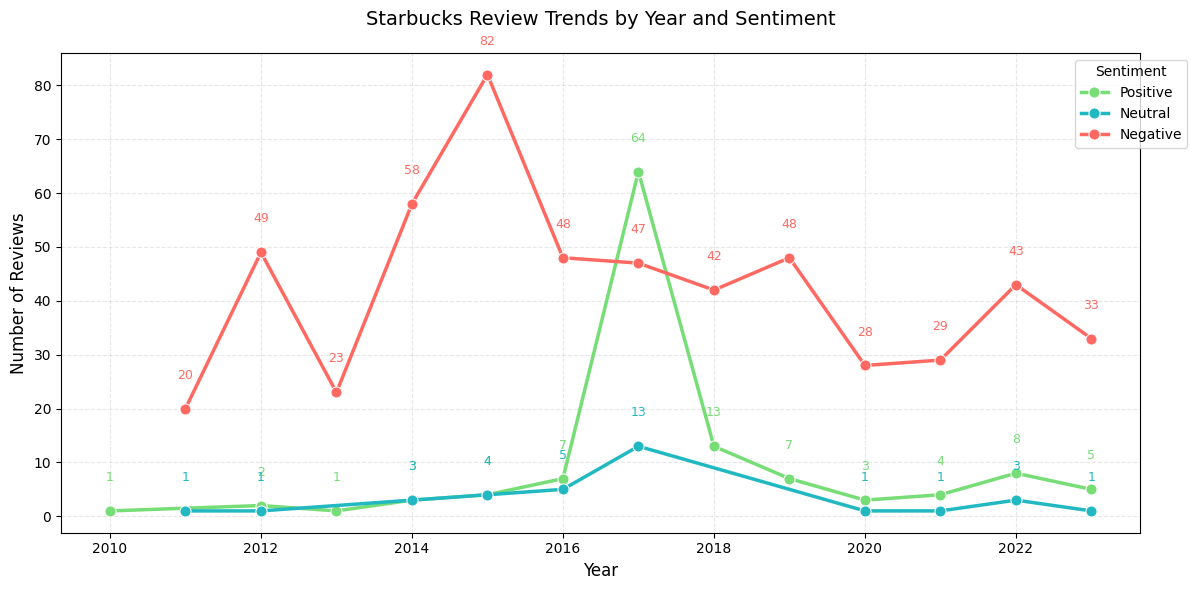

In [386]:

# 1. Ensure Date is datetime and extract year
df1['Year'] = pd.to_datetime(df1['Date']).dt.year

# 2. Group by Year and Sentiment
sentiment_year = df1.groupby(['Year', 'Sentiment']).size().unstack()

# 3. Plot
plt.figure(figsize=(12, 6))
palette = {'positive': '#77DD76', 'neutral': '#21B8C2', 'negative': '#FF6962'}  # Green, Blue, Red

for sentiment in ['positive', 'neutral', 'negative']:
    sns.lineplot(
        x=sentiment_year.index,
        y=sentiment_year[sentiment],
        marker='o',
        markersize=8,
        linewidth=2.5,
        color=palette[sentiment],
        label=sentiment.capitalize()
    )

# 4. Customize plot
plt.title('Starbucks Review Trends by Year and Sentiment', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1))

# 5. Add data labels
for year in sentiment_year.index:
    for sentiment in ['positive', 'neutral', 'negative']:
        count = sentiment_year.loc[year, sentiment]
        if pd.notna(count):
            plt.text(
                year, 
                count+5, 
                f'{int(count)}', 
                ha='center', 
                va='bottom',
                color=palette[sentiment],
                fontsize=9
            )

plt.tight_layout()
plt.show()

Original: My name is Ric **, I am journalist by profession. I'm sending this letter to Starbucks Coffee Company's head office to make a formal complaint, regarding the incident that happened to me on July 21st, between 4 to 4:30 pm local time at Starbucks coffee shop located on 195 Lake Shore East in Oakville, Ontario.
Cleaned: my name is ric i am journalist by profession im sending this letter to starbucks coffee companys head office to make a formal complaint regarding the incident that happened to me on july 21st between  to  pm local time at starbucks coffee shop located on  lake shore east in oakville ontario
Tokens: ['amber', 'ladonna', 'southwest', 'parkway', 'warm', 'welcoming', 'smile', 'voice', 'greet', 'drivethru', 'customer', 'service', 'spoton', 'order', 'right', 'smile', 'actually', 'star', 'available']
       Char_Length  Word_Length
count   705.000000   705.000000
mean    488.358865    36.817021
std     228.450152    17.332780
min      14.000000     2.000000
25%     285

/Users/linhdao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/linhdao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/linhdao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


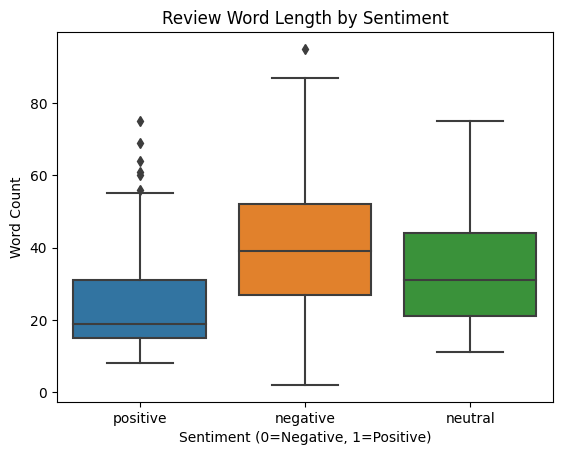

In [387]:
# Text CLeaning
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs, mentions, and special chars (keep only words and spaces)
    text = re.sub(r'http\S+|www\S+|@\w+|[^\w\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    # Remove numbers and numeric patterns
    text = re.sub(r'\b\d+\b', '', text)          # Standalone numbers
    text = re.sub(r'\$\d+', '', text)            # Prices ($4.50)
    text = re.sub(r'\d+min', '', text)           # Time (10min)
    return text

df1['Cleaned_Reviews'] = df1['Review'].apply(clean_text)
print("Original:", df1['Review'].iloc[701])
print("Cleaned:", df1['Cleaned_Reviews'].iloc[701])

# Basic Tokenization
stop_words = set(stopwords.words('english')) 
my_stopwords = list(stopwords.words('english')) + ['starbucks', 'coffee', 'a', 'nd', 'the', 'is', 'it', 'to', 'of', 'for', 'in', 'on', 'that', 'this', 'with', 'at', 'as', 'by', 'get', 'asked', 'got','also','every','went','back','would','said','told','always','get','made','one','dont','dont know','know','didnt','even','could','going','since','thing','give','day','drink','two cup','way','two','say']

def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in my_stopwords and len(word) > 2]  # Keep meaningful words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in my_stopwords]
    return ' '.join(tokens)


df1['Cleaned_Reviews'] = df1['Cleaned_Reviews'].apply(tokenize)

df1['Tokens'] = df1['Cleaned_Reviews'].apply(lambda x: x.split())
print("Tokens:", df1['Tokens'].iloc[0])

# Exploratory Data Analysis
df1['Char_Length'] = df1['Review'].apply(len)
df1['Word_Length'] = df1['Tokens'].apply(len)
print(df1[['Char_Length', 'Word_Length']].describe())

sns.boxplot(x='Sentiment', y='Word_Length', data=df1)
plt.title('Review Word Length by Sentiment')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Word Count')
plt.show()



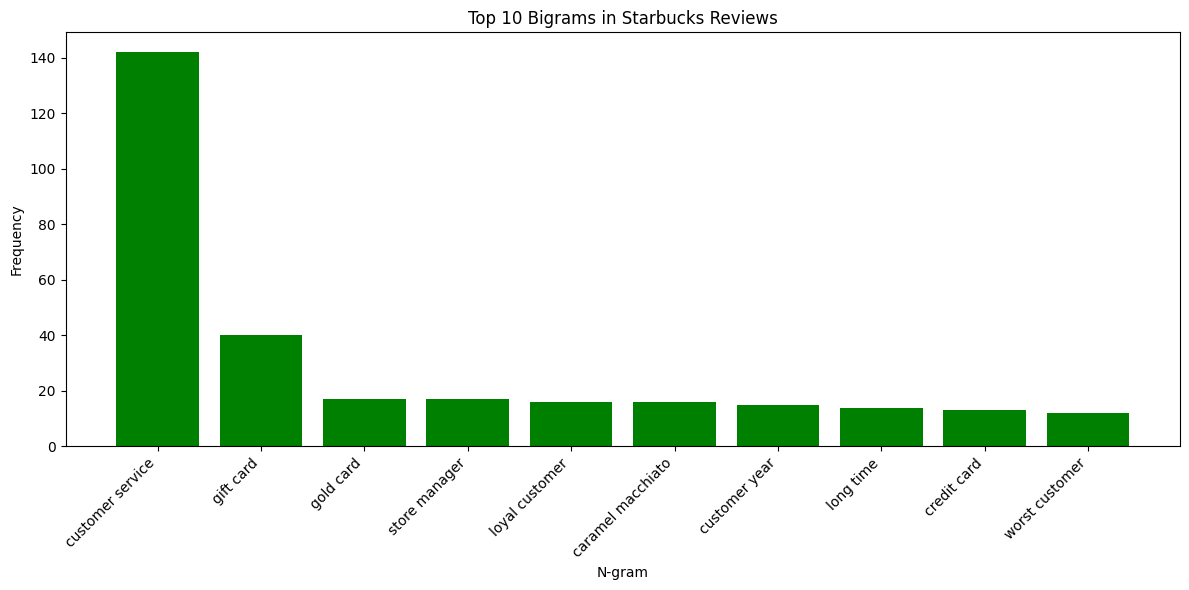

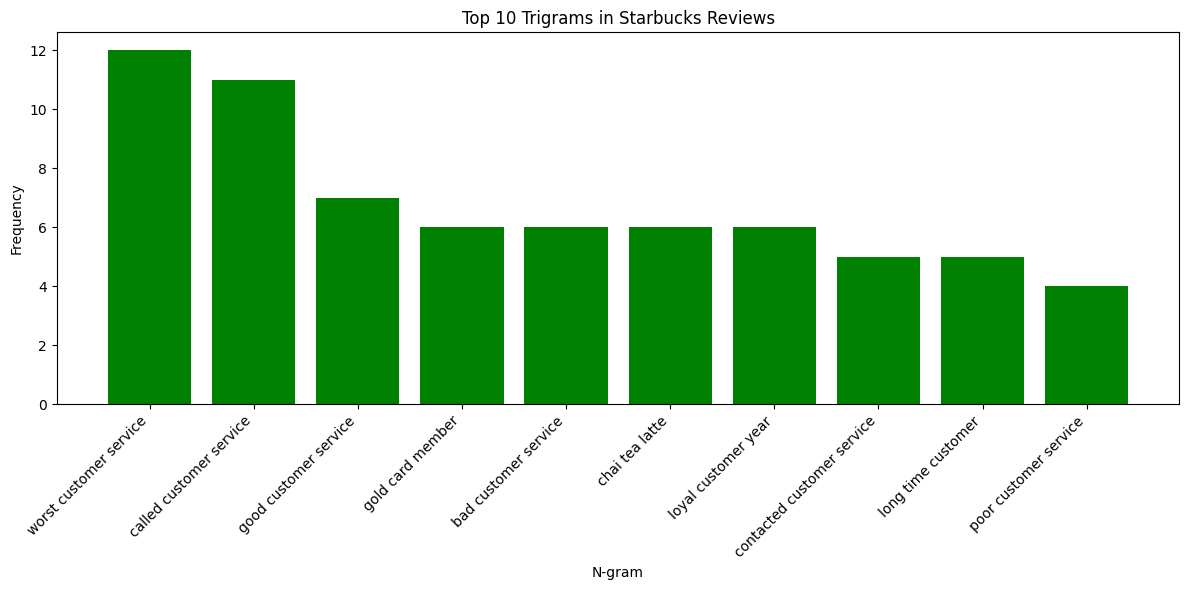

In [388]:
# N-Grams
reviews = df1['Cleaned_Reviews'].tolist()
# Bigrams (2-word phrases)
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=100)
bigram_counts = bigram_vectorizer.fit_transform(reviews)
# Trigrams (3-word phrases)
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english', max_features=100)
trigram_counts = trigram_vectorizer.fit_transform(reviews)

def get_top_ngrams(counts, vectorizer, top_n=10):
    ngram_counts = counts.sum(axis=0).A1  # Sum frequencies across documents
    ngram_indices = ngram_counts.argsort()[::-1][:top_n]  # Indices of top n-grams
    ngrams = [vectorizer.get_feature_names_out()[i] for i in ngram_indices]
    frequencies = [ngram_counts[i] for i in ngram_indices]
    return list(zip(ngrams, frequencies))

top_bigrams = get_top_ngrams(bigram_counts, bigram_vectorizer, top_n=10)
top_trigrams = get_top_ngrams(trigram_counts, trigram_vectorizer, top_n=10)

def plot_ngrams(ngrams, title):
    ngrams, frequencies = zip(*ngrams)
    plt.figure(figsize=(12, 6))
    plt.bar(ngrams, frequencies, color='green')
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.xlabel('N-gram')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_ngrams(top_bigrams, 'Top 10 Bigrams in Starbucks Reviews')
plot_ngrams(top_trigrams, 'Top 10 Trigrams in Starbucks Reviews')

## 1.5 Data Visualisation

### 1.5.1 Text Mining with Word Cloud
- Generate word clouds for positive vs. negative reviews

In [389]:
# Calculate Word Frequency by Sentiment
def get_word_freq(tokens_list):
    all_words = [word for tokens in tokens_list for word in tokens]
    return Counter(all_words)

positive_freq = get_word_freq(df1[df1['Sentiment'] == 'positive']['Tokens'])
neutral_freq = get_word_freq(df1[df1['Sentiment'] == 'neutral']['Tokens'])
negative_freq = get_word_freq(df1[df1['Sentiment'] == 'negative']['Tokens'])


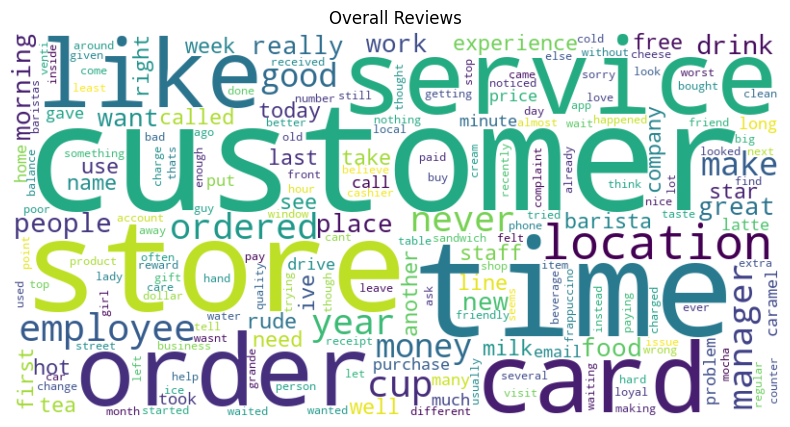

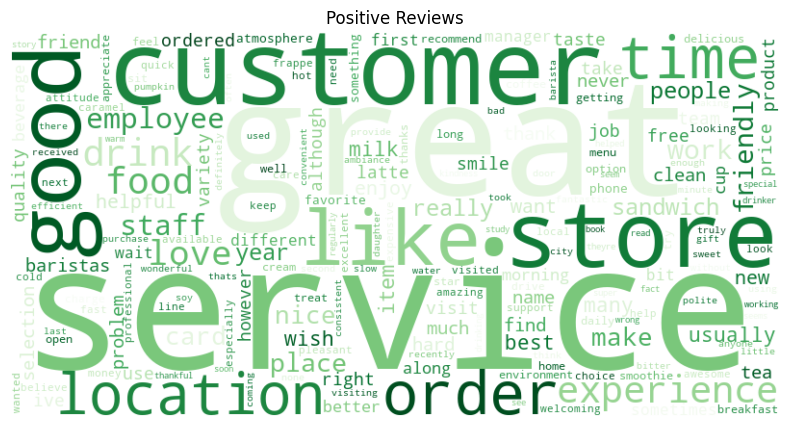

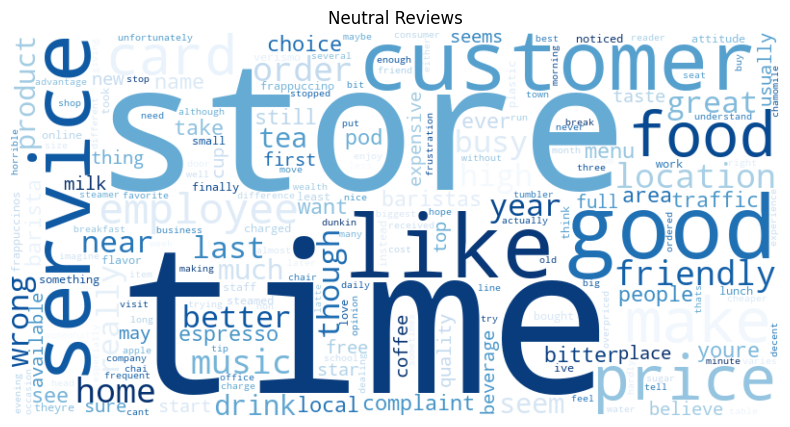

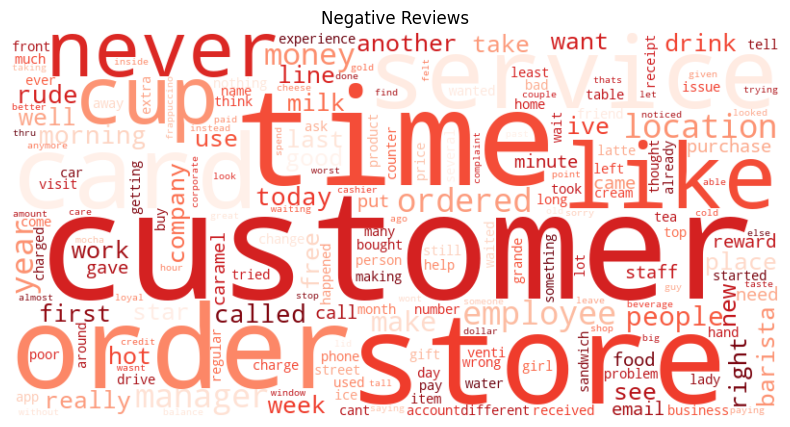

In [390]:
# Word Cloud

def plot_custom_wordcloud(freq_dict, title, colormap='viridis'):
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap=colormap
    ).generate_from_frequencies(freq_dict)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

#Plotting Word Clouds for overall
plot_custom_wordcloud(get_word_freq(df1['Tokens']), "Overall Reviews", 'viridis')

# Positive reviews (green theme)
plot_custom_wordcloud(positive_freq, "Positive Reviews", 'Greens')
# Neutral reviews (blue theme)
plot_custom_wordcloud(neutral_freq, "Neutral Reviews", 'Blues')
# Negative reviews (red theme)
plot_custom_wordcloud(negative_freq, "Negative Reviews", 'Reds')

### 1.5.2 Text Mining with Frequency Plots
- Plot top 20 most frequent words
- Compare term frequencies by sentiment

/Users/linhdao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/linhdao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/linhdao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


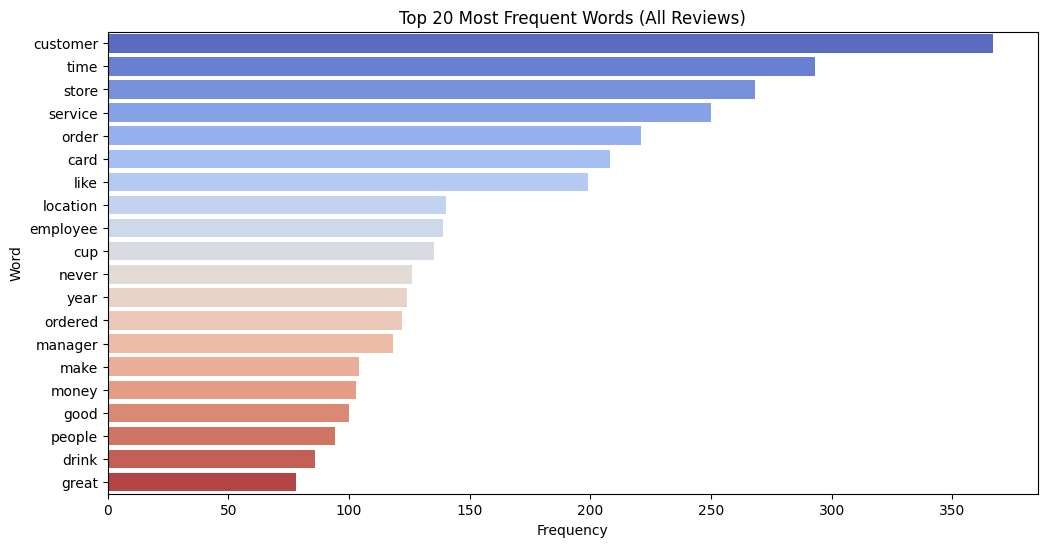

In [391]:
# Word Frequency (1)

all_tokens = [word for tokens in df1['Tokens'] for word in tokens]
word_freq = Counter(all_tokens).most_common(20)

freq_df = pd.DataFrame(word_freq, columns=['Word', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(data=freq_df, y='Word', x='Count', palette='coolwarm')
plt.title('Top 20 Most Frequent Words (All Reviews)')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

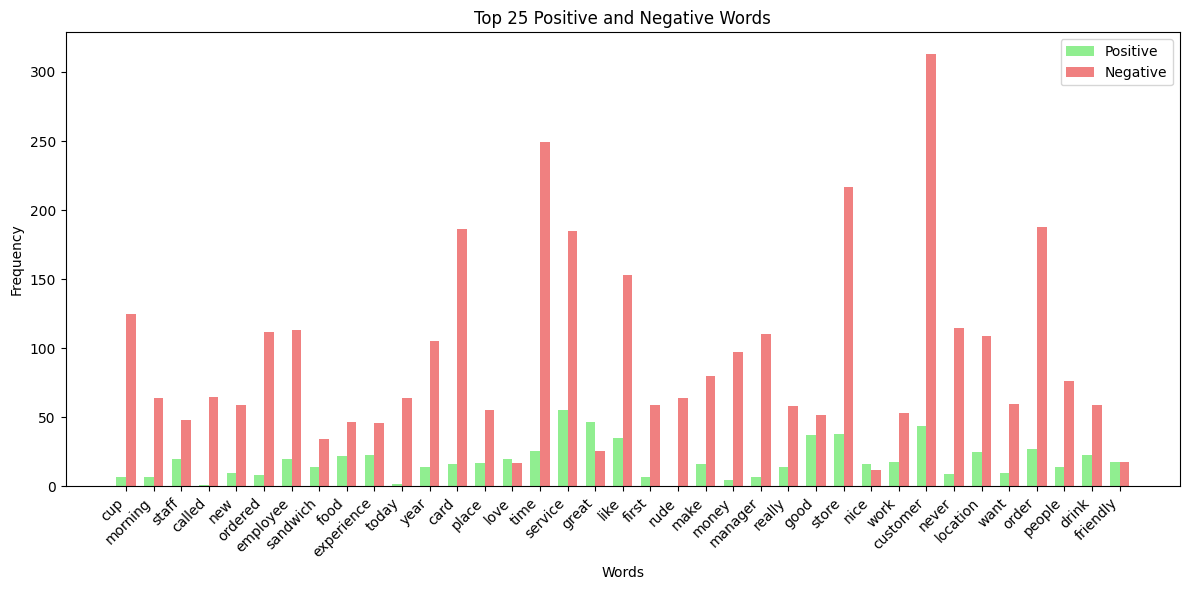

In [392]:


# Prepare data for clustered bar chart
positive_words, positive_counts = zip(*positive_freq.most_common(25))
negative_words, negative_counts = zip(*negative_freq.most_common(25))

# Create a combined list of unique words
all_words = list(set(positive_words) | set(negative_words))

# Create arrays for word frequencies
positive_freq_array = np.array([positive_freq[word] if word in positive_freq else 0 for word in all_words])
negative_freq_array = np.array([negative_freq[word] if word in negative_freq else 0 for word in all_words])

# Create the bar chart
x = np.arange(len(all_words))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, positive_freq_array, width, label='Positive', color='lightgreen')
bars2 = ax.bar(x + width/2, negative_freq_array, width, label='Negative', color='lightcoral')

# Add labels, title, and legend
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 25 Positive and Negative Words')
ax.set_xticks(x)
ax.set_xticklabels(all_words, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [393]:
# Group the headlines by year
yearly_counts = df1.groupby(df1['Year'])['Cleaned_Reviews'].apply(list)

# Create a dictionary to store yearly word counts
yearly_word_counts = {}

for year, words in yearly_counts.items():
    all_year_text = ' '.join(words)
    yearly_word_counts[year] = Counter(all_year_text.split())

# Print the top 10 words for each year (Optional: Can be adjusted to more or fewer)
for year, counts in yearly_word_counts.items():
    print(f"\nTop 10 words for {year}:")
    print(counts.most_common(10))



Top 10 words for 2010:
[('good', 2), ('found', 1), ('overrated', 1), ('taste', 1), ('survey', 1), ('bitter', 1), ('comment', 1), ('speedway', 1), ('gas', 1), ('station', 1)]

Top 10 words for 2011:
[('time', 14), ('customer', 12), ('location', 11), ('manager', 10), ('store', 9), ('year', 7), ('never', 7), ('order', 7), ('ive', 5), ('employee', 5)]

Top 10 words for 2012:
[('customer', 23), ('store', 21), ('time', 21), ('never', 16), ('manager', 16), ('order', 16), ('like', 15), ('year', 14), ('employee', 14), ('cup', 14)]

Top 10 words for 2013:
[('card', 18), ('time', 18), ('customer', 14), ('store', 10), ('order', 10), ('service', 9), ('gave', 9), ('car', 8), ('employee', 8), ('wrong', 7)]

Top 10 words for 2014:
[('card', 39), ('order', 26), ('customer', 26), ('store', 25), ('like', 20), ('cup', 17), ('time', 17), ('service', 17), ('manager', 17), ('barista', 15)]

Top 10 words for 2015:
[('customer', 55), ('time', 46), ('store', 36), ('order', 34), ('service', 30), ('employee', 25

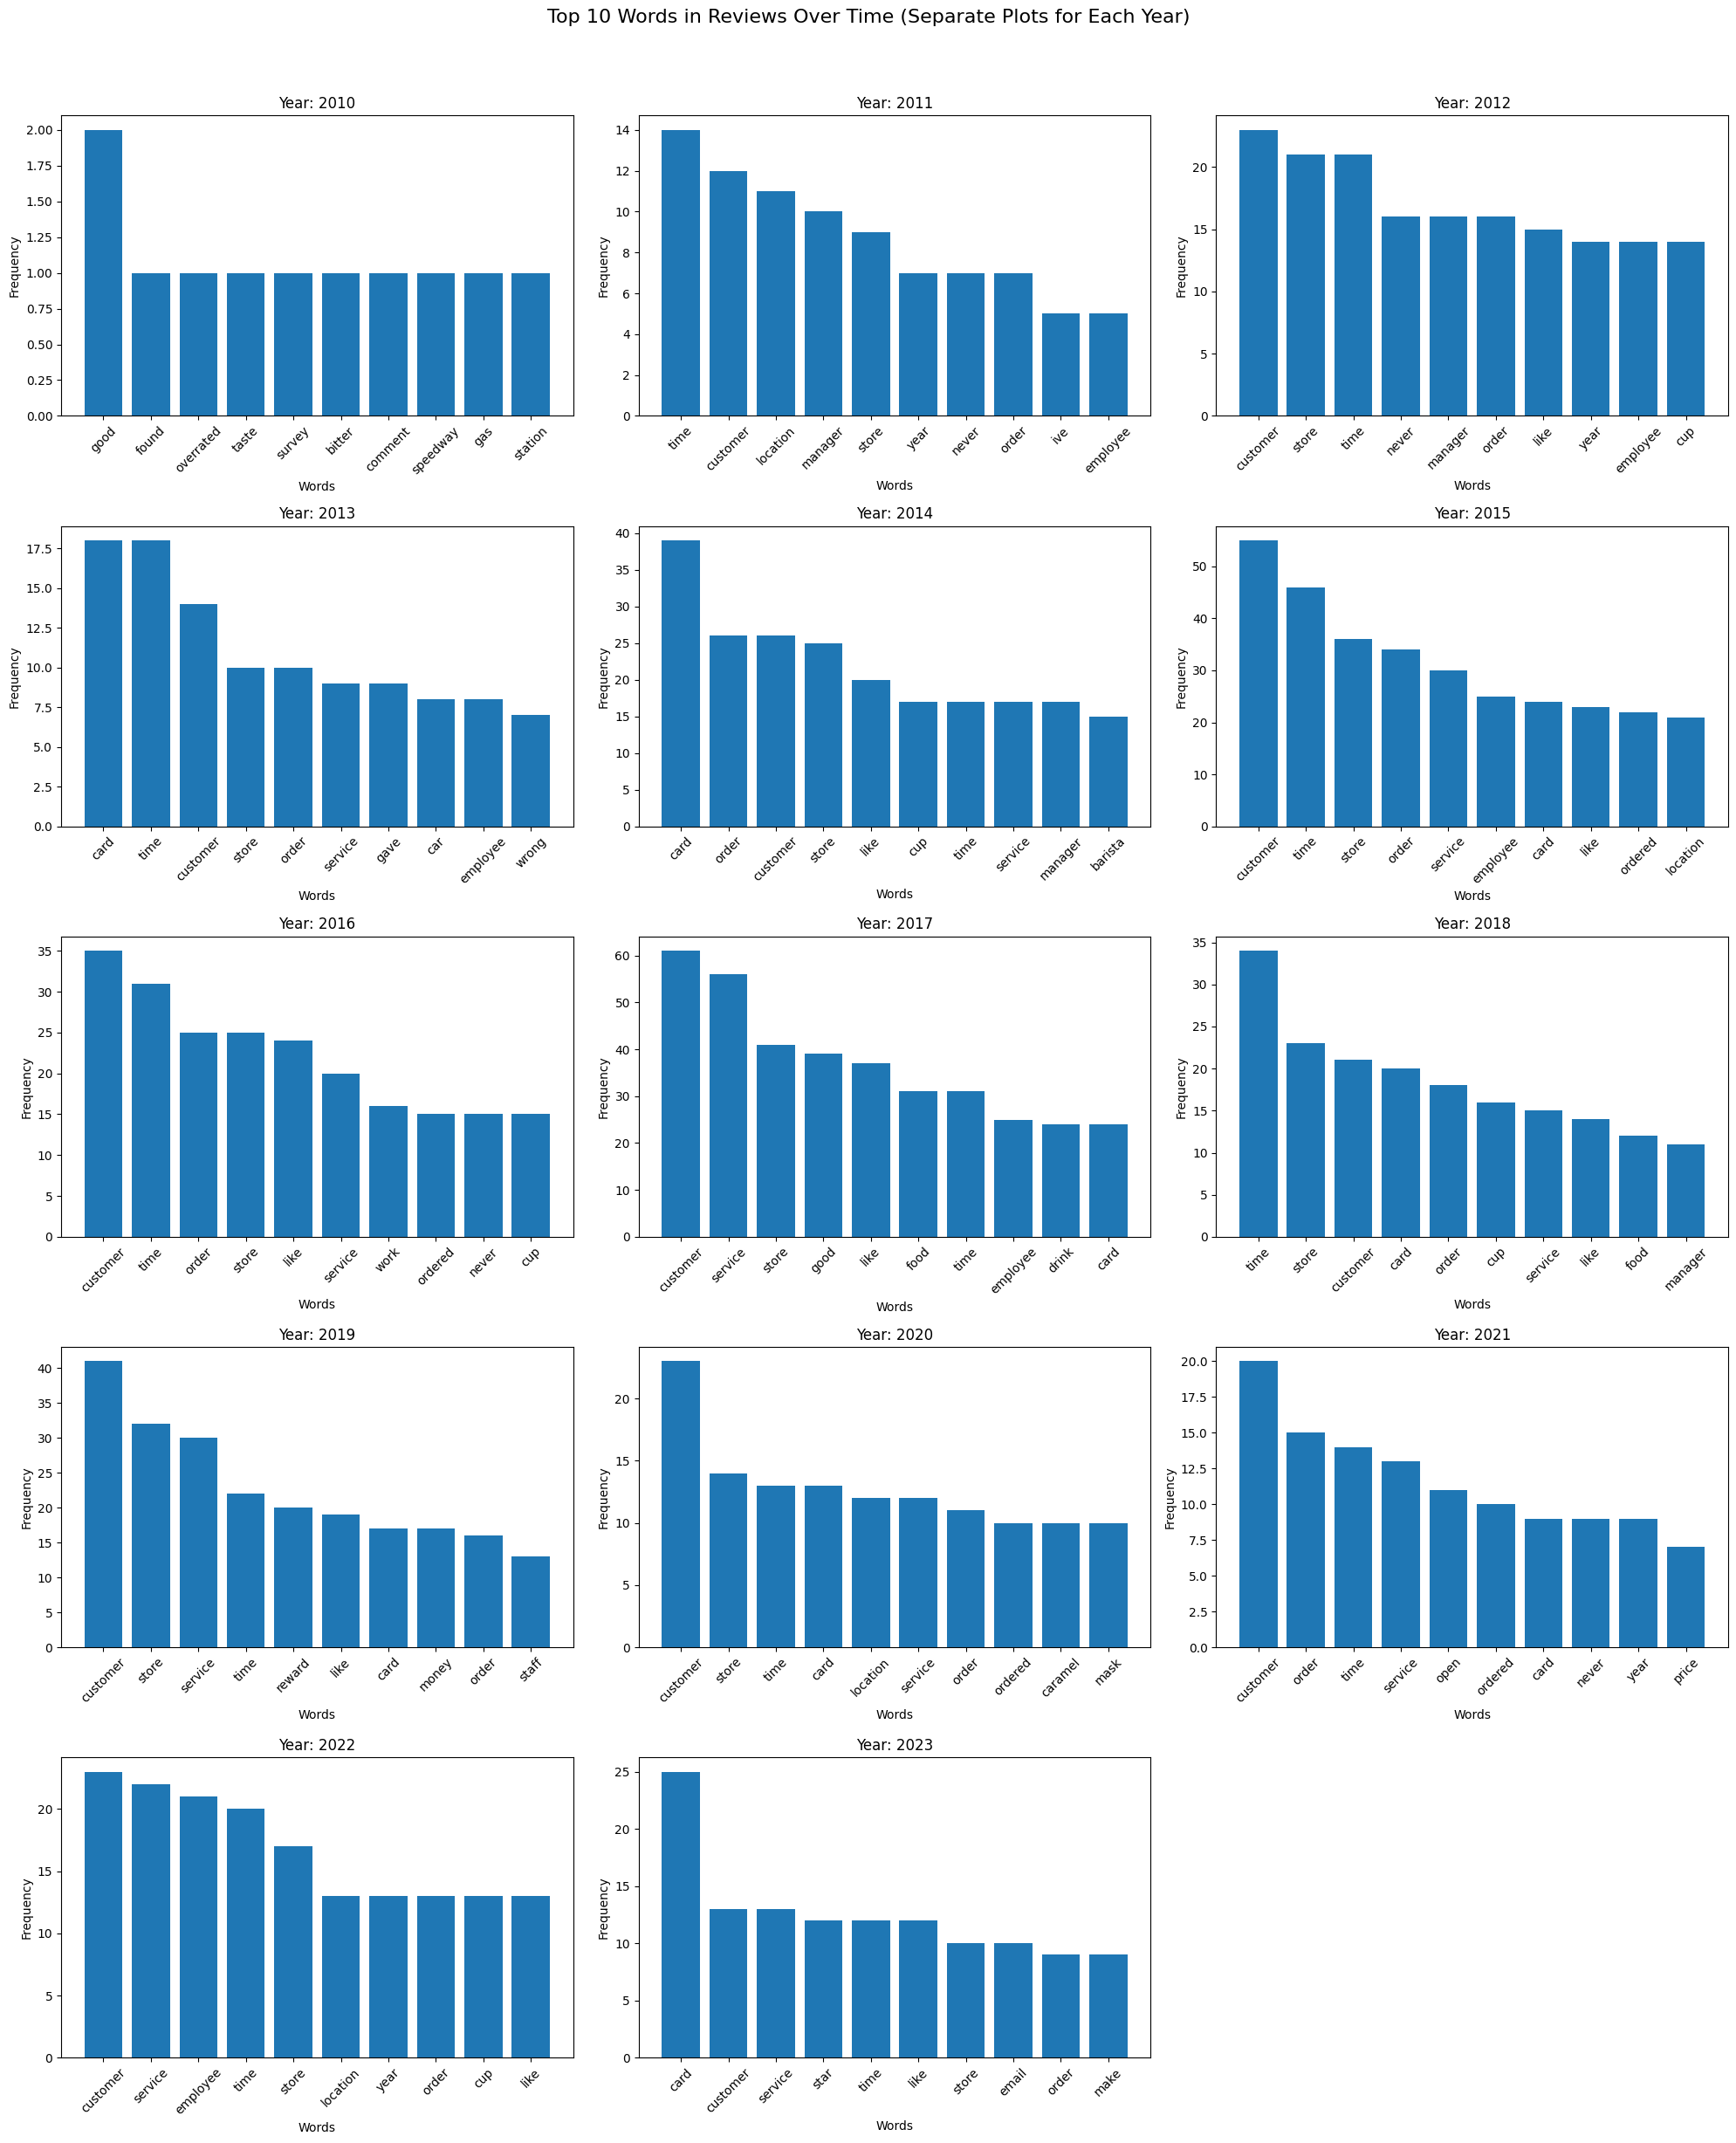

In [397]:

yearly_word_counts = {
2010: [('good', 2), ('found', 1), ('overrated', 1), ('taste', 1), ('survey', 1), ('bitter', 1), ('comment', 1), ('speedway', 1), ('gas', 1), ('station', 1)],
2011: [('time', 14), ('customer', 12), ('location', 11), ('manager', 10), ('store', 9), ('year', 7), ('never', 7), ('order', 7), ('ive', 5), ('employee', 5)],
2012: [('customer', 23), ('store', 21), ('time', 21), ('never', 16), ('manager', 16), ('order', 16), ('like', 15), ('year', 14), ('employee', 14), ('cup', 14)],
2013: [('card', 18), ('time', 18), ('customer', 14), ('store', 10), ('order', 10), ('service', 9), ('gave', 9), ('car', 8), ('employee', 8), ('wrong', 7)],
2014: [('card', 39), ('order', 26), ('customer', 26), ('store', 25), ('like', 20), ('cup', 17), ('time', 17), ('service', 17), ('manager', 17), ('barista', 15)],
2015: [('customer', 55), ('time', 46), ('store', 36), ('order', 34), ('service', 30), ('employee', 25), ('card', 24), ('like', 23), ('ordered', 22), ('location', 21)],
2016: [('customer', 35), ('time', 31), ('order', 25), ('store', 25), ('like', 24), ('service', 20), ('work', 16), ('ordered', 15), ('never', 15), ('cup', 15)],
2017: [('customer', 61), ('service', 56), ('store', 41), ('good', 39), ('like', 37), ('food', 31), ('time', 31), ('employee', 25), ('drink', 24), ('card', 24)],
2018: [('time', 34), ('store', 23), ('customer', 21), ('card', 20), ('order', 18), ('cup', 16), ('service', 15), ('like', 14), ('food', 12), ('manager', 11)],
2019: [('customer', 41), ('store', 32), ('service', 30), ('time', 22), ('reward', 20), ('like', 19), ('card', 17), ('money', 17), ('order', 16), ('staff', 13)],
2020: [('customer', 23), ('store', 14), ('time', 13), ('card', 13), ('location', 12), ('service', 12), ('order', 11), ('ordered', 10), ('caramel', 10), ('mask', 10)],
2021: [('customer', 20), ('order', 15), ('time', 14), ('service', 13), ('open', 11), ('ordered', 10), ('card', 9), ('never', 9), ('year', 9), ('price', 7)],
2022: [('customer', 23), ('service', 22), ('employee', 21), ('time', 20), ('store', 17), ('location', 13), ('year', 13), ('order', 13), ('cup', 13), ('like', 13)],
2023: [('card', 25), ('customer', 13), ('service', 13), ('star', 12), ('time', 12), ('like', 12), ('store', 10), ('email', 10), ('order', 9), ('make', 9)]
}
# Create subplots for each year
num_years = len(yearly_word_counts)
num_cols = 3  # Number of columns for subplots
num_rows = (num_years + num_cols - 1) // num_cols  # Calculate rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))
fig.suptitle('Top 10 Words in Reviews Over Time (Separate Plots for Each Year)', fontsize=16)

# Iterate through years and plot
for i, (year, word_counts) in enumerate(yearly_word_counts.items()):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    words, frequencies = zip(*word_counts)  # Unzip word_counts
    ax.bar(words, frequencies)

    ax.set_title(f'Year: {year}')
    ax.set_xlabel('Words')
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45)  # Changed 'horizontalalignment' to 'ha'

# Remove extra subplots if any
for i in range(num_years, num_rows * num_cols):
    fig.delaxes(axes[i // num_cols, i % num_cols])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
plt.show()

# 2. LDA
- Documen-term matrix
- Train model
- Visualise topics

In [398]:
# Random sampling (adjust sample_size as needed)
sample_size = 700  # Typical for mid-sized datasets
sampled_df = df1.sample(n=sample_size, random_state=42)  # Reproducible sampling

vectorizer = CountVectorizer(
    max_df=0.95,     # Ignore overly common words
    min_df=5,        # Require words to appear in ≥5 reviews
    stop_words='english',
    max_features=8000  # Limit vocabulary size
)

# Add custom stopwords
vectorizer.stop_words_ = vectorizer.get_stop_words().union(set(my_stopwords))

# Create document-term matrix
dtm = vectorizer.fit_transform(sampled_df['Cleaned_Reviews'])
print(f"DTM shape: {dtm.shape}")  # Should be (sample_size, vocab_size)
lda_model = LatentDirichletAllocation(
    n_components=10,           # Start with 10 topics
    random_state=42,
    learning_method='online',  # Better for larger datasets
    max_iter=15,               # More iterations for stability
    batch_size=256             # Faster training
)

lda_model.fit(dtm)
# Print topics with top 10 words
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda_model.components_):
    top_features_ind = topic.argsort()[:-10 - 1:-1]  # Top 10 word indices
    top_features = [feature_names[i] for i in top_features_ind]
    print(f"Topic {topic_idx}: {', '.join(top_features)}")

DTM shape: (700, 886)
Topic 0: card, customer, account, service, called, gift, email, money, store, order
Topic 1: star, reward, purchase, time, use, free, program, mask, bonus, offer
Topic 2: customer, service, time, drink, store, food, ive, like, great, cup
Topic 3: milk, order, time, ordered, customer, cup, tea, latte, grande, make
Topic 4: order, caramel, time, location, long, wait, drive, mocha, drink, ordered
Topic 5: customer, store, like, time, employee, manager, location, year, service, people
Topic 6: sandwich, cheese, food, man, delicious, enter, employee, old, usually, serving
Topic 7: ice, extra, gave, cup, tip, manager, cold, water, ordered, hot
Topic 8: store, cup, order, minute, hot, ordered, waited, bag, blend, service
Topic 9: line, people, order, store, morning, waiting, open, person, counter, music


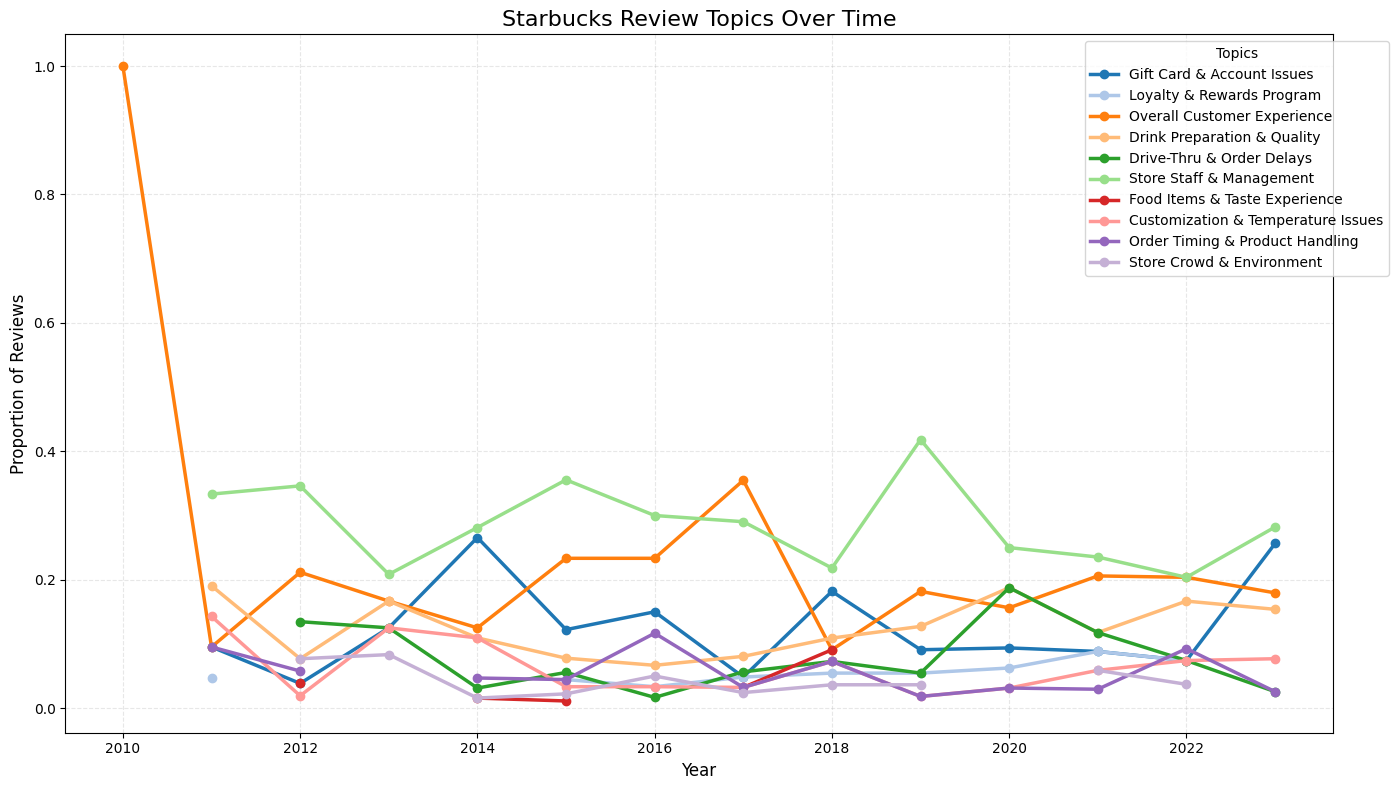

In [399]:
# Get topic labels from your existing model
feature_names = vectorizer.get_feature_names_out()
topic_labels = []
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-5:-1]]  # Top 5 words
    topic_labels.append(f"Topic {topic_idx}: " + ", ".join(top_words))

# Example custom naming (adjust based on your topics):
custom_names = {
    0: "Gift Card & Account Issues", 
    1: "Loyalty & Rewards Program",
    2: "Overall Customer Experience",
    3: "Drink Preparation & Quality",
    4: "Drive-Thru & Order Delays",
    5: "Store Staff & Management",
    6: "Food Items & Taste Experience",
    7: "Customization & Temperature Issues",
    8: "Order Timing & Product Handling",
    9: "Store Crowd & Environment"
}

# Transform ALL reviews (not just sample)
full_dtm = vectorizer.transform(df1['Cleaned_Reviews'])  # Use your cleaned column
topic_probs = lda_model.transform(full_dtm)
df1['dominant_topic'] = topic_probs.argmax(axis=1)

# Get topic proportions per year
yearly_topic_counts = df1.groupby(['Year', 'dominant_topic']).size().unstack()
yearly_topic_props = yearly_topic_counts.div(yearly_topic_counts.sum(axis=1), axis=0)

# Fill missing years if needed
all_years = range(df1['Year'].min(), df1['Year'].max()+1)
yearly_topic_props = yearly_topic_props.reindex(all_years, fill_value=0)

plt.figure(figsize=(14, 8))
colors = plt.cm.tab20.colors  # Color palette for 10 topics

for topic in range(10):
    plt.plot(
        yearly_topic_props.index,
        yearly_topic_props[topic],
        label=custom_names[topic],
        color=colors[topic],
        marker='o',
        linewidth=2.5
    )

plt.title('Starbucks Review Topics Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Proportion of Reviews', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), title='Topics')
plt.tight_layout()
plt.show()